<h1 style="text-align:center">Intel Image Classification using CNN</h1>

The obejective is to calssify image data of Natural Scenes around the world. The data contains around 25k images of size 150x150 distributed under 6 categories. Please refer to <a href="https://www.kaggle.com/datasets/puneet6060/intel-image-classification">here</a>. 

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

There are around 14k images in Train, 3k in Test. 

In [462]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import shutil
import zipfile
import matplotlib.pyplot as plt

Load the training and validiation sets

In [3]:
data_dir = 'data\\seg_train\\seg_train'
batch_size = 64
train_ds = keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training",
  seed=123, image_size=(150, 150), batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", 
     seed=123,  image_size=(150, 150), batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [4]:
train_ds.element_spec

(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [58]:
class_names = train_ds.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Look at the some of images at the training

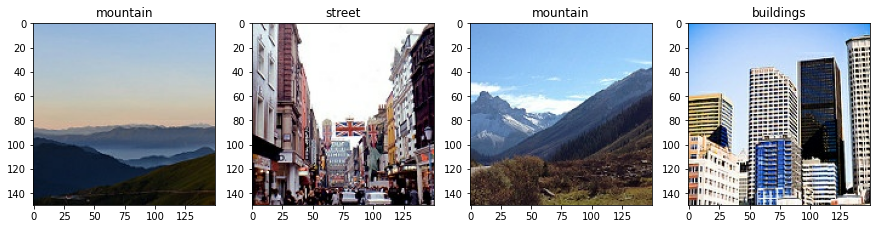

In [463]:
gif, ax = plt.subplots(1, 4, figsize=(15, 15))

for images, labels in train_ds.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype("uint8"))
        ax[i].set_title(class_names[labels[i]])


plt.show()

## build a CNN model for prediction

In [21]:
# build model
regularizer=tf.keras.regularizers.L1(0.0001)

model = keras.Sequential()
model.add(keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)))
model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizer))    
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizer))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizer))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizer))
# model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizer))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizer))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dropout(rate=.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(6, activation='softmax'))


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)       

In [464]:
# it is used to adaptively decrease  the learning rate 
class AdapativeLearingRate(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        scheduled_lr = .95 * lr
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f"\nEpoch {epoch}: Learning rate is {scheduled_lr}.")


In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:

history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[AdapativeLearingRate()])

Epoch 1/100
176/176 [==============================] - ETA: 0s - loss: 1.6527 - accuracy: 0.4619
Epoch 0: Learning rate is 0.0009500000451225787.
176/176 [==============================] - 64s 362ms/step - loss: 1.6527 - accuracy: 0.4619 - val_loss: 1.1900 - val_accuracy: 0.6098
Epoch 2/100
176/176 [==============================] - ETA: 0s - loss: 1.1686 - accuracy: 0.5851
Epoch 1: Learning rate is 0.0009025000152178108.
176/176 [==============================] - 62s 350ms/step - loss: 1.1686 - accuracy: 0.5851 - val_loss: 1.1471 - val_accuracy: 0.5848
Epoch 3/100
176/176 [==============================] - ETA: 0s - loss: 1.0215 - accuracy: 0.6356
Epoch 2: Learning rate is 0.0008573750033974647.
176/176 [==============================] - 67s 378ms/step - loss: 1.0215 - accuracy: 0.6356 - val_loss: 1.0001 - val_accuracy: 0.6450
Epoch 4/100
176/176 [==============================] - ETA: 0s - loss: 0.9401 - accuracy: 0.6782
Epoch 3: Learning rate is 0.0008145062311086804.
176/176 [=====

176/176 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8704
Epoch 29: Learning rate is 0.00021463872035383245.
176/176 [==============================] - 64s 364ms/step - loss: 0.4612 - accuracy: 0.8704 - val_loss: 0.5571 - val_accuracy: 0.8382
Epoch 31/100
176/176 [==============================] - ETA: 0s - loss: 0.4548 - accuracy: 0.8727
Epoch 30: Learning rate is 0.0002039067905570846.
176/176 [==============================] - 64s 361ms/step - loss: 0.4548 - accuracy: 0.8727 - val_loss: 0.5419 - val_accuracy: 0.8425
Epoch 32/100
176/176 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.8737
Epoch 31: Learning rate is 0.00019371145172044634.
176/176 [==============================] - 64s 363ms/step - loss: 0.4491 - accuracy: 0.8737 - val_loss: 0.5635 - val_accuracy: 0.8350
Epoch 33/100
176/176 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.8736
Epoch 32: Learning rate is 0.00018402588466415182.
176/176 [=======

176/176 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8963
Epoch 58: Learning rate is 4.849451343034161e-05.
176/176 [==============================] - 64s 366ms/step - loss: 0.3864 - accuracy: 0.8963 - val_loss: 0.5440 - val_accuracy: 0.8475
Epoch 60/100
176/176 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.8991
Epoch 59: Learning rate is 4.606978654919658e-05.
176/176 [==============================] - 64s 362ms/step - loss: 0.3832 - accuracy: 0.8991 - val_loss: 0.5352 - val_accuracy: 0.8493
Epoch 61/100
176/176 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.8991
Epoch 60: Learning rate is 4.3766295493696814e-05.
176/176 [==============================] - 63s 356ms/step - loss: 0.3807 - accuracy: 0.8991 - val_loss: 0.5362 - val_accuracy: 0.8503
Epoch 62/100
176/176 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8986
Epoch 61: Learning rate is 4.1577981755835934e-05.
176/176 [========

176/176 [==============================] - ETA: 0s - loss: 0.3606 - accuracy: 0.9046
Epoch 87: Learning rate is 1.0956635469483444e-05.
176/176 [==============================] - 67s 381ms/step - loss: 0.3606 - accuracy: 0.9046 - val_loss: 0.5376 - val_accuracy: 0.8521
Epoch 89/100
176/176 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.9052
Epoch 88: Learning rate is 1.0408803609607275e-05.
176/176 [==============================] - 67s 380ms/step - loss: 0.3618 - accuracy: 0.9052 - val_loss: 0.5349 - val_accuracy: 0.8542
Epoch 90/100
176/176 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.9057
Epoch 89: Learning rate is 9.888363774734898e-06.
176/176 [==============================] - 69s 394ms/step - loss: 0.3614 - accuracy: 0.9057 - val_loss: 0.5362 - val_accuracy: 0.8525
Epoch 91/100
176/176 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.9078
Epoch 90: Learning rate is 9.393945629199151e-06.
176/176 [========

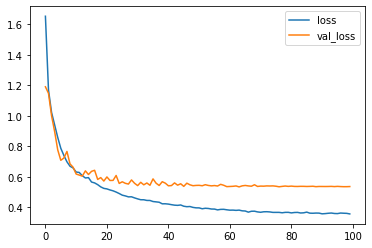

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

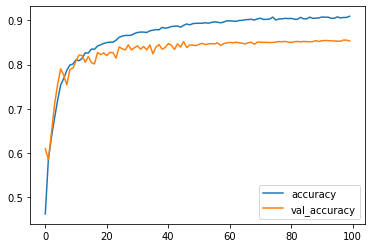

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

Load test data

In [35]:
#
data_test_dir = 'data\\seg_test\\seg_test'
test_ds = keras.utils.image_dataset_from_directory(data_test_dir,
   image_size=(150, 150), batch_size=3000, shuffle=False)


Found 3000 files belonging to 6 classes.


In [36]:
loss, acc= model.evaluate(test_ds)

1/1 [==============================] - 5s 5s/step - loss: 0.5206 - accuracy: 0.8647


In [37]:
predict_probs = model.predict(test_ds)
predict_labels = tf.math.argmax(predict_probs, axis=1)

true_imgs = next(iter(test_ds))[0].numpy()
true_labels = next(iter(test_ds))[1].numpy()

## Confusion matrix

In [48]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(true_labels, predict_labels.numpy())

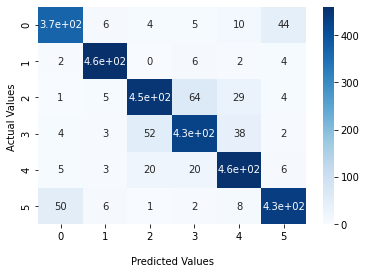

In [49]:
import seaborn as sns

ax = sns.heatmap(conf_mat, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

The error is mostly due to mixing up classes <code> buildings </code> and <code>street</code>;  and classes <code> mountain </code> and  <code> forest </code>. Lets look at some examples from these classes.

<code> buildings </code> and <code>street</code>:

In [137]:
num_test_classes = []
for i, name in enumerate(class_names):
    test_dir = os.path.join(data_test_dir, name)
    num_test_classes.append(len(os.listdir(test_dir)))
    
num_test_classes = np.array(num_test_classes)

<BarContainer object of 6 artists>

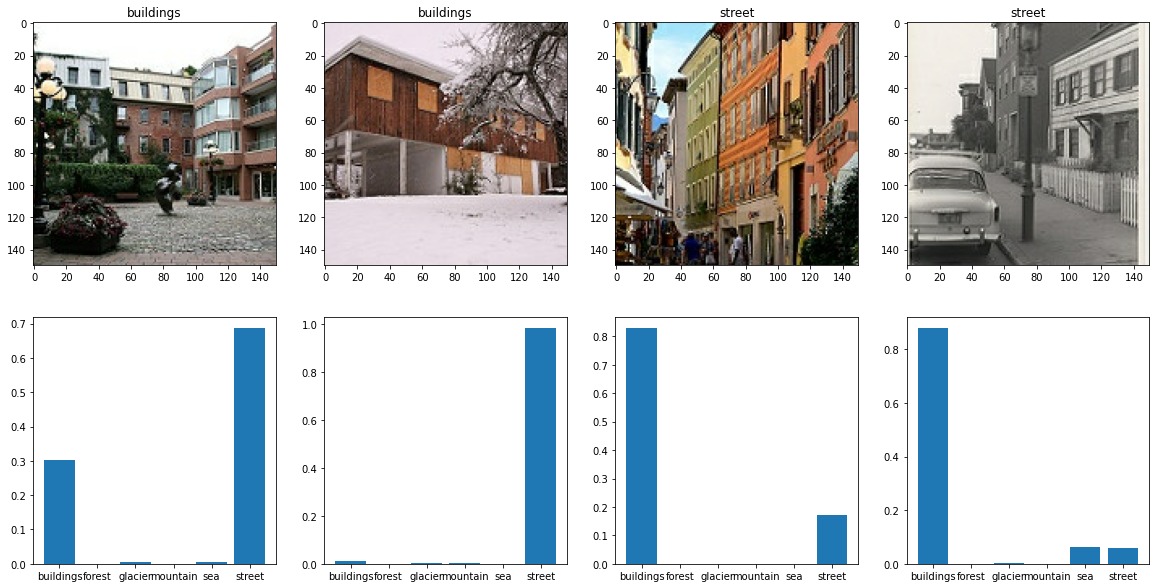

In [138]:
idx_miss_build = np.where(predict_labels[:num_test_classes[0]]==5)[0]

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0, 0].imshow(true_imgs[idx_miss_build[0]].astype("uint8"))
ax[0, 0].set_title(class_names[true_labels[idx_miss_build[0]]])

ax[0, 1].imshow(true_imgs[idx_miss_build[2]].astype("uint8"))
ax[0, 1].set_title(class_names[true_labels[idx_miss_build[2]]])

id_start = sum(num_test_classes[[0, 1, 2, 3, 4]])
idx_miss_street = np.where(predict_labels[-num_test_classes[-1]:]==0)[0]+ id_start

ax[0, 2].imshow(true_imgs[idx_miss_street[0]].astype("uint8"))
ax[0, 2].set_title(class_names[true_labels[idx_miss_street[0]]])

ax[0, 3].imshow(true_imgs[idx_miss_street[40]].astype("uint8"))
ax[0, 3].set_title(class_names[true_labels[idx_miss_street[40]]])



ax[1, 0].bar(class_names, predict_probs[idx_miss_build[0]])

ax[1, 1].bar(class_names, predict_probs[idx_miss_build[2]])

ax[1, 2].bar(class_names, predict_probs[idx_miss_street[0]])

ax[1, 3].bar(class_names, predict_probs[idx_miss_street[40]])

It can be seen that there are similarties among the buildings and street images and therefore the model gets confused to sepertate these images. For some cases, even for human, it is not easy to  how the images should be classified


<code> mountain </code> and  <code> forest </code>:

<BarContainer object of 6 artists>

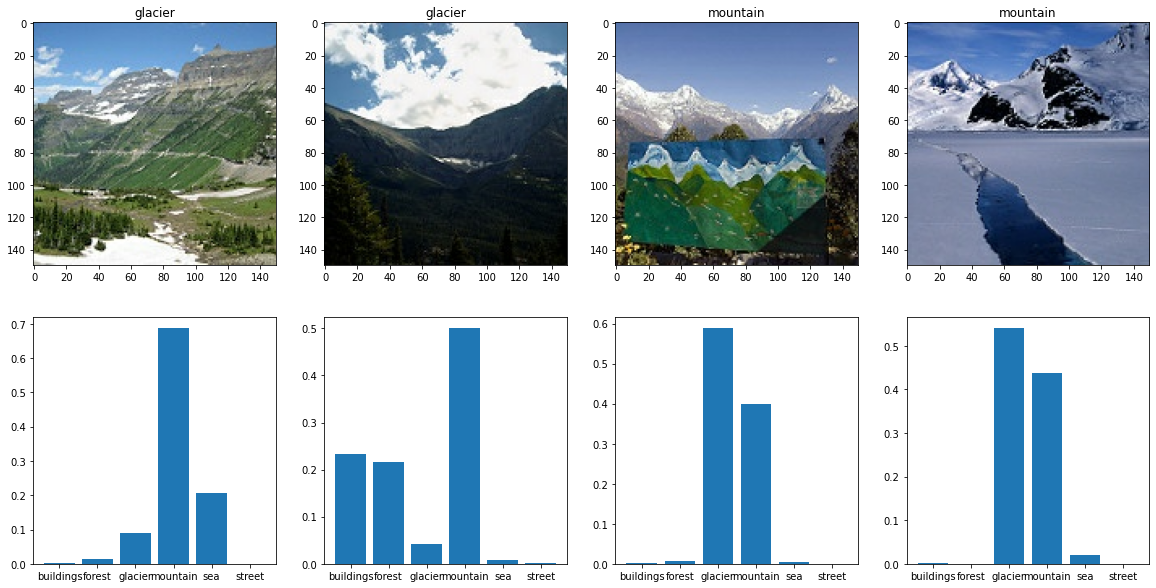

In [139]:
ind_start = num_test_classes[[0, 1]].sum()
idx_miss_glac = np.where(predict_labels[ind_start:ind_start+num_test_classes[2]]==3)[0]+ind_start

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0, 0].imshow(true_imgs[idx_miss_glac[0]].astype("uint8"))
ax[0, 0].set_title(class_names[true_labels[idx_miss_glac[0]]])

ax[0, 1].imshow(true_imgs[idx_miss_glac[2]].astype("uint8"))
ax[0, 1].set_title(class_names[true_labels[idx_miss_glac[2]]])

ind_start = num_test_classes[[0, 1, 2]].sum()
idx_miss_mount = np.where(predict_labels[ind_start:ind_start+num_test_classes[3]]==2)[0]+ind_start
ax[0, 2].imshow(true_imgs[idx_miss_mount[0]].astype("uint8"))
ax[0, 2].set_title(class_names[true_labels[idx_miss_mount[0]]])

ax[0, 3].imshow(true_imgs[idx_miss_mount[3]].astype("uint8"))
ax[0, 3].set_title(class_names[true_labels[idx_miss_mount[3]]])



ax[1, 0].bar(class_names, predict_probs[idx_miss_forest[0]])

ax[1, 1].bar(class_names, predict_probs[idx_miss_forest[2]])

ax[1, 2].bar(class_names, predict_probs[idx_miss_mount[0]])

ax[1, 3].bar(class_names, predict_probs[idx_miss_mount[3]])

## Visualizing intermediate feature maps

In [154]:
input_layer = model.layers[0].input
outputs = [layer.output for layer in model.layers]
visualize_model = keras.models.Model(inputs=input_layer, outputs=outputs)

Select an image from the test set

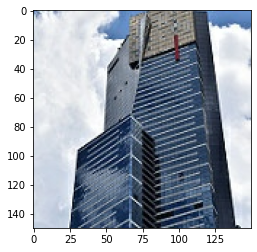

In [458]:
vis_imgs = true_imgs[0]
plt.imshow(vis_imgs.astype("uint8"))

Compute the outputs of the different layers

In [459]:
feature_map = visualize_model.predict(vis_imgs[None, :, :, :])

In [460]:
# helper funtion to plot the feature maps
def plot_feature_maps(feature_map, s=2.5):
    num_channels = feature_map.shape[3]
    num_row = 16
    num_col = int(num_channels/num_row)
    fig, ax = plt.subplots(num_col, num_row, figsize=(25, s))
    k=0
    for i in range(num_col):
        for j in range(num_row):
            if num_col == 1:
                ax[j].imshow(feature_map[0,:,:, j], aspect='auto', cmap='viridis')
                ax[j].axis('off')
            else:
                ax[i, j].imshow(feature_map[0,:,:, k], aspect='auto', cmap='viridis')
                ax[i, j].axis('off')
                k +=1
    plt.subplots_adjust(wspace=.00, hspace=.00)


feature maps at <code>conv2d_6</code> output:

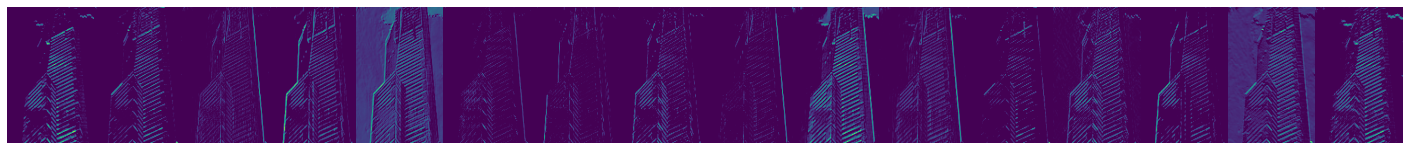

In [432]:
plot_feature_maps(feature_map[1],  2.5)

feature maps at <code>conv2d_7</code> output:

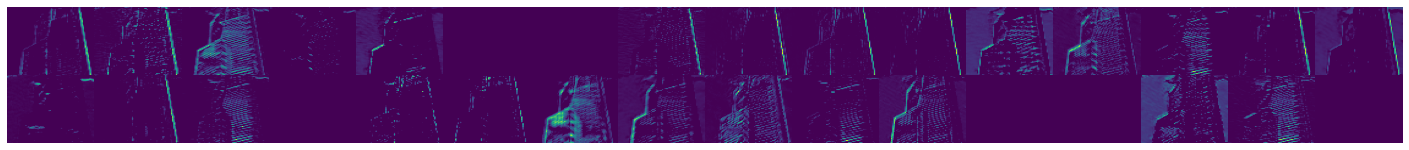

In [439]:

plot_feature_maps(feature_map[3],  5)


feature maps at <code>conv2d_8</code> output:

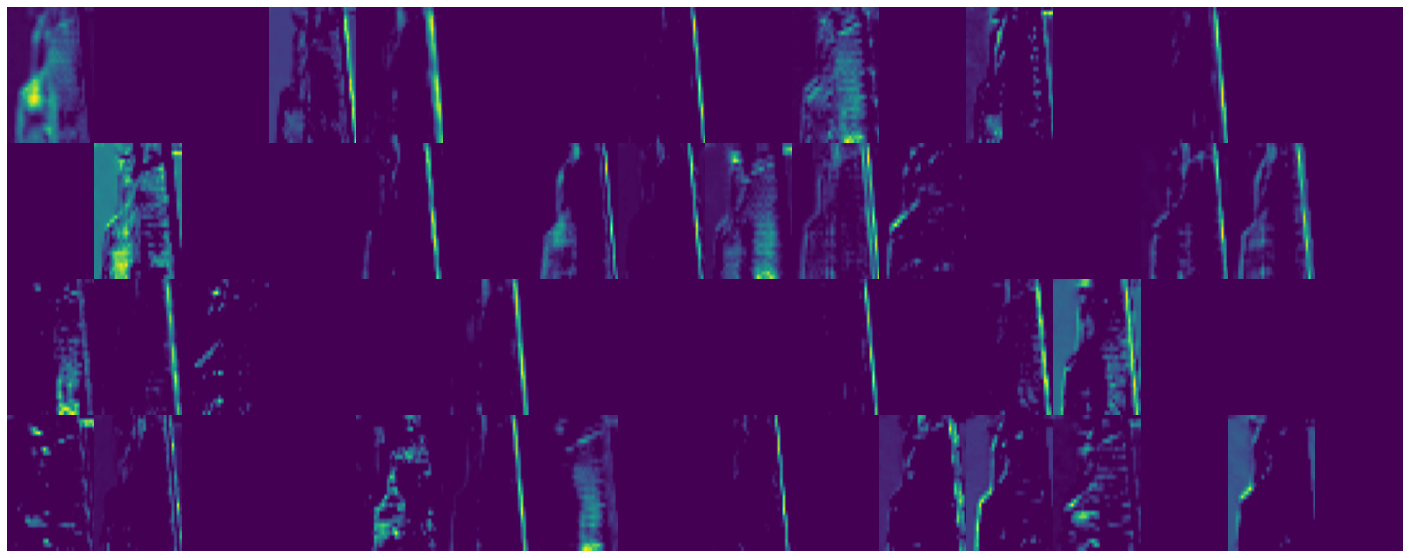

In [447]:
plot_feature_maps(feature_map[5], 10)

### Conclusion

The obejective of this study was to classify image data of Natural Scenes around the world. Using a simple CNN model, we achieved accuracy of 0.86. The accuracy may be improved using other techniques such as data augmentation.
